In [13]:
# Core imports
import os
import subprocess
import numpy as np
import pandas as pd
import h5py
import random
from urllib.request import urlretrieve
import matplotlib.pyplot as plt


# TensorFlow/Keras imports for model loading
import tensorflow as tf
from keras.models import model_from_json

# SEAM imports
import seam
from seam import Compiler, Attributer, Clusterer, MetaExplainer, Identifier
from seam.logomaker_batch.batch_logo import BatchLogo


In [14]:
#open libraries from library_selection.ipynb
import pickle

with open('libraries/hyperparam_libraries.pkl', 'rb') as f:
    libraries = pickle.load(f)
    dev_loci = libraries['dev']
    hk_loci = libraries['hk']

print(len(dev_loci), len(hk_loci))

8 8


In [15]:
## import model
import os
from urllib.request import urlretrieve
from keras.models import model_from_json

model_dir = 'models/deepstarr'
os.makedirs(model_dir, exist_ok=True)

model_json_file = os.path.join(model_dir, 'deepstarr.model.json')
model_weights_file = os.path.join(model_dir, 'deepstarr.model.h5')

with open(model_json_file, 'r') as f:
    model_json = f.read()

model = model_from_json(model_json, custom_objects={'Functional': tf.keras.Model})
model.load_weights(model_weights_file)

print("Model loaded successfully!")

2026-01-21 14:52:33.337119: W tensorflow/c/c_api.cc:291] Operation '{name:'Conv1D_4_5/kernel/Assign' id:8596 op device:{requested: '', assigned: ''} def:{{{node Conv1D_4_5/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Conv1D_4_5/kernel, Conv1D_4_5/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Model loaded successfully!


In [16]:
## load deepSHAP
def seam_deepshap(x_mut, task_index):
    x_ref = x_mut
    import time
    import tensorflow as tf
    from keras.models import model_from_json
    import numpy as np
    import random

    # Configuration
    attribution_method = 'deepshap'  # or 'gradientshap', 'integratedgradients', etc.
    task_index = task_index  # 0 for Dev, 1 for Hk
    gpu = 0  # GPU device number
    save_data = True
    save_path = './attributions'  # Where to save results
    os.makedirs(save_path, exist_ok=True)

    # Model paths
    keras_model_json = 'models/deepstarr/deepstarr.model.json'
    keras_model_weights = 'models/deepstarr/deepstarr.model.h5'

    if attribution_method == 'deepshap':
        try:
            # Disable eager execution first
            tf.compat.v1.disable_eager_execution()
            tf.compat.v1.disable_v2_behavior()
            print("TensorFlow eager execution disabled for DeepSHAP compatibility")
            
            # Import SHAP to configure handlers
            try:
                import shap
            except ImportError:
                print("ERROR: SHAP package is not installed.")
                print("To install SHAP for DeepSHAP attribution, run:")
                print("pip install kundajelab-shap==1")
                raise ImportError("SHAP package required for DeepSHAP attribution")
            
            # Handle AddV2 operation (element-wise addition) as a linear operation
            shap.explainers.deep.deep_tf.op_handlers["AddV2"] = shap.explainers.deep.deep_tf.passthrough

            # Load the model after eager execution is disabled
            keras_model = model_from_json(open(keras_model_json).read(), custom_objects={'Functional': tf.keras.Model})
            np.random.seed(113)
            random.seed(0)
            keras_model.load_weights(keras_model_weights)
            model = keras_model
            
            # Rebuild model to ensure proper graph construction
            _ = model(tf.keras.Input(shape=model.input_shape[1:]))
            
        except ImportError:
            raise
        except Exception as e:
            print(f"Warning: Could not setup TensorFlow for DeepSHAP. Error: {e}")
            print("DeepSHAP may not work properly.")
        
        # Create attributer for DeepSHAP
        def deepstarr_compress(x):
            """DeepSTARR compression function for DeepSHAP."""
            if hasattr(x, 'outputs'):
                return tf.reduce_sum(x.outputs[task_index], axis=-1)
            else:
                return x

        attributer = Attributer(
            model,
            method=attribution_method,
            task_index=task_index,
            compress_fun=deepstarr_compress
        )

        attributer.show_params(attribution_method)

        t1 = time.time()
        attributions = attributer.compute(
            x_ref=x_ref,
            x=x_mut,
            save_window=None,
            batch_size=16,
            gpu=gpu,
        )
        t2 = time.time() - t1
        print(f'Attribution time: {t2/60:.2f} minutes')
    else:
        # Use unified Attributer for other methods
        attributer = Attributer(
            model,
            method=attribution_method,
            task_index=task_index,
            compress_fun=lambda x: x,
            pred_fun=model.predict_on_batch,
        )

        attributer.show_params(attribution_method)

        t1 = time.time()
        attributions = attributer.compute(
            x_ref=x_ref,
            x=x_mut,
            save_window=None,
            batch_size=256,
            gpu=gpu
        )
        t2 = time.time() - t1
        print(f'Attribution time: {t2/60:.2f} minutes')

    return attributions

In [17]:
dev_loci["test_idx"][0]

17977

Processing Developmental sequences...
TensorFlow eager execution disabled for DeepSHAP compatibility


2026-01-21 14:52:34.234639: W tensorflow/c/c_api.cc:291] Operation '{name:'batch_normalization_76_6/moving_variance/Assign' id:9657 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_76_6/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_76_6/moving_variance, batch_normalization_76_6/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Parameters for deepshap:

Required:
x: array, Input sequences to compute attributions for

Optional:
background: array, Background sequences for DeepSHAP (optional). Shape: (N, L, A). If not provided, will generate shuffled backgrounds using num_shuffles.

Common Optional:
x_ref: array, Reference sequence for comparison (optional). Shape: (1, L, A). Used for padding in windowed analysis when save_window is specified. Not used for DeepSHAP background.
save_window: list, Window [start, end] to compute attributions (optional). When provided with x_ref, allows computing attributions for a subset of positions while maintaining full sequence context. Input x should contain only the windowed region with shape (N, end-start, A), and x_ref provides the full-length context with shape (1, L, A). Example: [100, 200] computes attributions for positions 100-200.
Done 0 examples of 8
Attribution time: 0.02 minutes


Processing logos:   0%|          | 0/8 [00:00<?, ?it/s]findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
Processing logos: 100%|██████████| 8/8 [00:00<00:00, 44.90it/s]


Processing Housekeeping sequences...
TensorFlow eager execution disabled for DeepSHAP compatibility


2026-01-21 14:52:38.057450: W tensorflow/c/c_api.cc:291] Operation '{name:'batch_normalization_76_7/moving_variance/Assign' id:11487 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_76_7/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_76_7/moving_variance, batch_normalization_76_7/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Parameters for deepshap:

Required:
x: array, Input sequences to compute attributions for

Optional:
background: array, Background sequences for DeepSHAP (optional). Shape: (N, L, A). If not provided, will generate shuffled backgrounds using num_shuffles.

Common Optional:
x_ref: array, Reference sequence for comparison (optional). Shape: (1, L, A). Used for padding in windowed analysis when save_window is specified. Not used for DeepSHAP background.
save_window: list, Window [start, end] to compute attributions (optional). When provided with x_ref, allows computing attributions for a subset of positions while maintaining full sequence context. Input x should contain only the windowed region with shape (N, end-start, A), and x_ref provides the full-length context with shape (1, L, A). Example: [100, 200] computes attributions for positions 100-200.
Done 0 examples of 8
Attribution time: 0.02 minutes


Processing logos:   0%|          | 0/8 [00:00<?, ?it/s]findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
Processing logos: 100%|██████████| 8/8 [00:00<00:00, 47.43it/s]


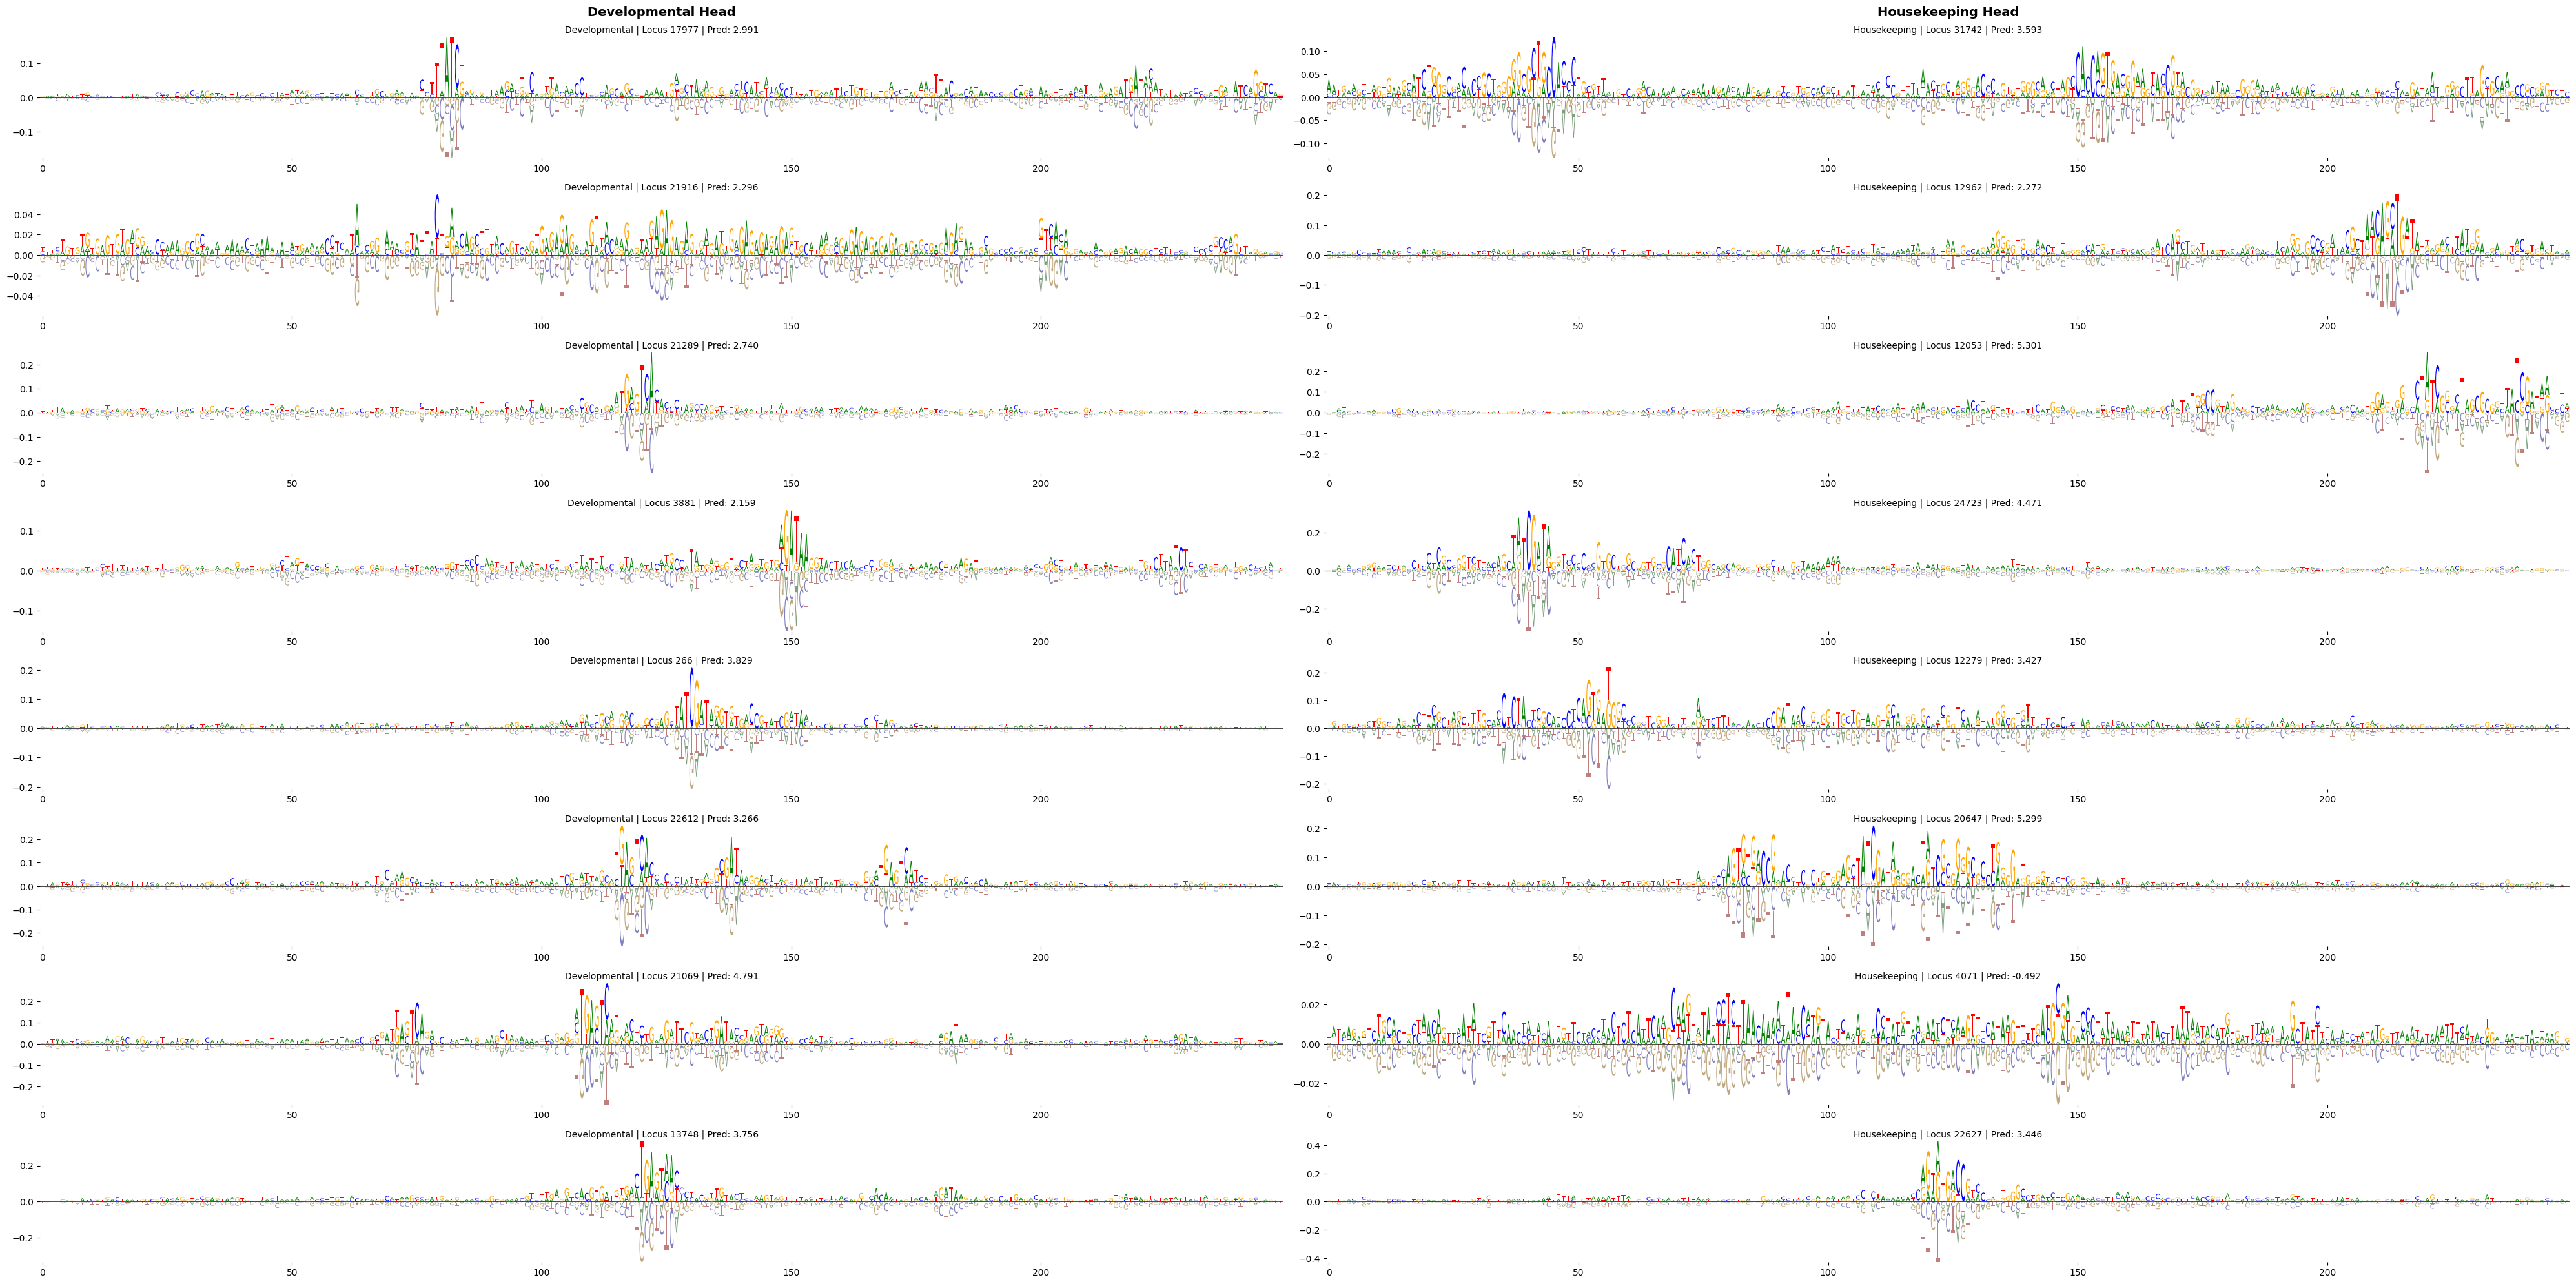

In [18]:
## Visualize attribution maps for all sequences in both libraries

import matplotlib.pyplot as plt
from seam.logomaker_batch.batch_logo import BatchLogo
import numpy as np

# Configuration
alphabet = ['A', 'C', 'G', 'T']
save_logos = False
save_path = './library_attributions'

# Determine number of sequences to plot (use minimum of both libraries)
n_dev = len(dev_loci['ohe_seq'])
n_hk = len(hk_loci['ohe_seq'])
n_rows = max(n_dev, n_hk)  # or min(n_dev, n_hk) if you only want matching pairs

# Create figure with subplots: rows = sequences, cols = heads
fig, axes = plt.subplots(n_rows, 2, figsize=(40, 2.5 * n_rows))

# Ensure axes is 2D even if only one row
if n_rows == 1:
    axes = axes.reshape(1, -1)

# Process each head
for col_idx, (task_index, loci, task_name) in enumerate([
    (0, dev_loci, 'Developmental'),
    (1, hk_loci, 'Housekeeping')
]):
    print(f"Processing {task_name} sequences...")
    
    # Get number of sequences for this head
    n_seqs = len(loci['ohe_seq'])
    
    # Stack sequences properly (handles list of arrays)
    all_seqs = np.stack(loci['ohe_seq'], axis=0)
    
    # Compute attributions for this batch
    attributions = seam_deepshap(all_seqs, task_index=task_index)
    
    # Create BatchLogo for all sequences
    batch_logo = BatchLogo(
        attributions,
        alphabet=alphabet,
        font_name='Arial Rounded MT Bold',
        fade_below=0.5,
        shade_below=0.5,
        width=0.9,
        center_values=True,
        batch_size=n_seqs
    )
    
    batch_logo.process_all()
    
    # Plot each sequence in its row (only up to n_seqs for this library)
    for row_idx in range(n_seqs):
        ax = axes[row_idx, col_idx]
        
        # Draw logo on the subplot
        batch_logo.draw_single(row_idx, ax=ax, border=False)
        
        # Add title with info
        pred_value = loci['activity'][row_idx]
        test_idx = loci['test_idx'][row_idx]
        
        title = f'{task_name} | Locus {test_idx} | Pred: {pred_value:.3f}'
        ax.set_title(title, fontsize=10, pad=5)
        
    
    # If this head has fewer sequences, clear extra rows
    for row_idx in range(n_seqs, n_rows):
        axes[row_idx, col_idx].axis('off')

# Add column labels
axes[0, 0].text(0.5, 1.15, 'Developmental Head', 
                ha='center', va='bottom', transform=axes[0, 0].transAxes,
                fontsize=14, fontweight='bold')
axes[0, 1].text(0.5, 1.15, 'Housekeeping Head',
                ha='center', va='bottom', transform=axes[0, 1].transAxes,
                fontsize=14, fontweight='bold')

plt.tight_layout()

plt.show()